# 2. Разведочный анализ данных (EDA)

## Цели этапа
1. Анализ распределения целевой переменной
2. Исследование категориальных признаков
3. Анализ числовых признаков  
4. Поиск корреляций и взаимосвязей
5. Формулировка выводов и гипотез

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../data/Churn_Modelling.csv')

df.info()

numeric_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
categorical_features = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Tenure']
target = 'Exited'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


## 2.1 Анализ целевой переменной

Анализируем дисбаланс классов - это критично для выбора метрик и стратегии борьбы с дисбалансом.

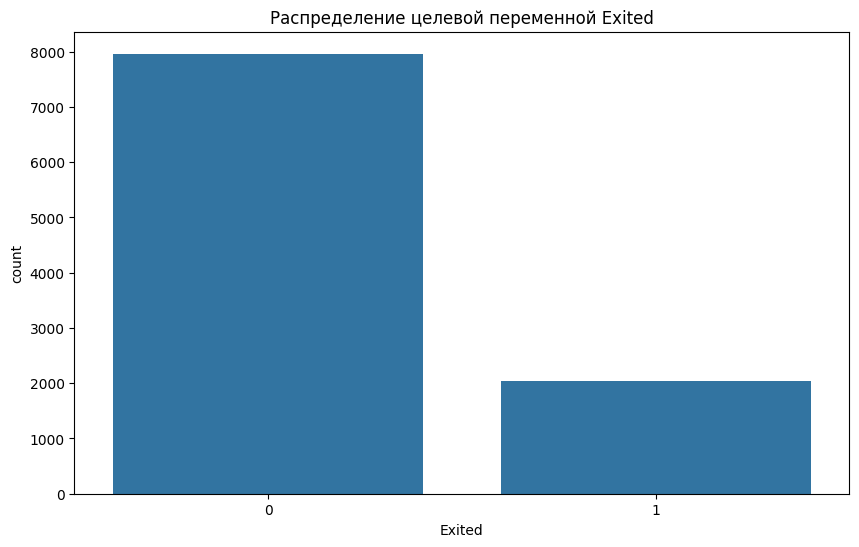

In [2]:
plt.figure(figsize=(10,6))
sb.countplot(data=df, x=target)
plt.title('Распределение целевой переменной Exited')
plt.show()

In [3]:
churn_count = df['Exited'].value_counts().min()
remaining_customers = df['Exited'].value_counts().max()
print(f"Сколько человек попали под отток: {churn_count}")
print(f"Сколько человек остались пользоваться услугами банака: {remaining_customers}")

Сколько человек попали под отток: 2038
Сколько человек остались пользоваться услугами банака: 7964


In [4]:
churn_rate = df['Exited'].value_counts(normalize=True) * 100
print(f"Процент оттока: {churn_rate[1]:.1f}%")

Процент оттока: 20.4%


Можем заметить, что у нас присутствует дисбаланс классов: из 10002 клиентов 2038 человек перестали пользоваться услугами банка, а 7964 остались преданны банку и продолжают пользоваться его услугами. Следовательно в дальнейшем этапе "Подготовка данных к обучению" мы будем использовать методы балансировки классов, чтобы наша модель давала более точные результаты

## 2.2 Исследование категориальных признаков

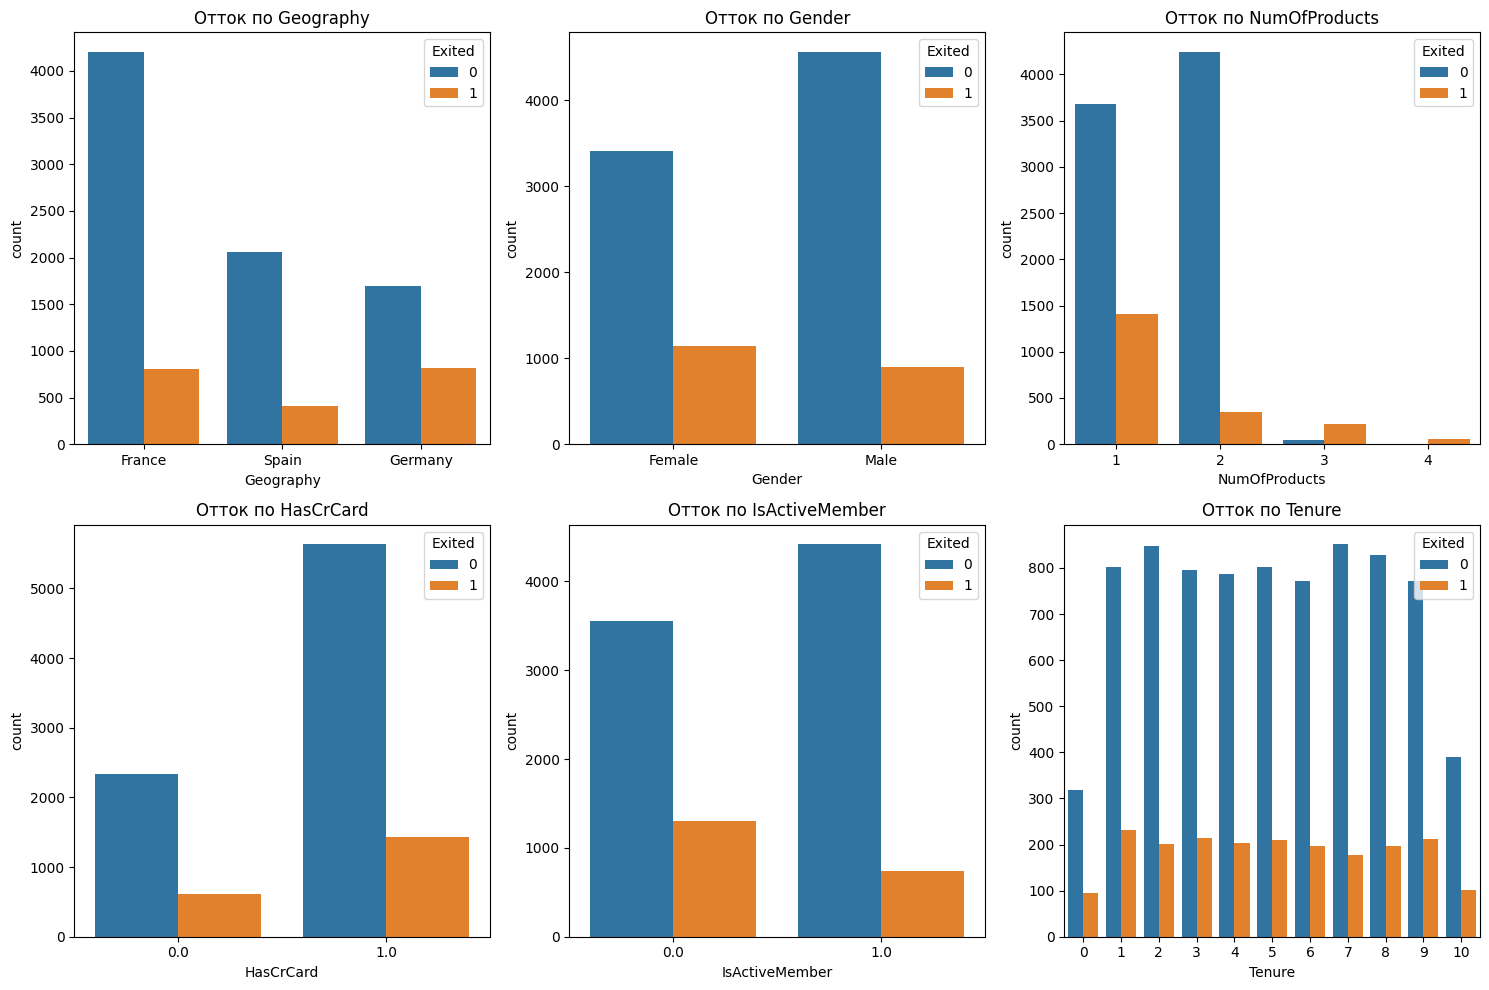

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(categorical_features):
    ax = axes[i//3, i%3]
    sb.countplot(data=df, x=col, hue='Exited', ax=ax)
    ax.set_title(f'Отток по {col}')
    
plt.tight_layout()
plt.show()

In [6]:
for column in categorical_features:
    product_churn = df.groupby(column)['Exited'].mean() * 100
    print(product_churn)
    print('-'*50)

Geography
France     16.154767
Germany    32.470120
Spain      16.673395
Name: Exited, dtype: float64
--------------------------------------------------
Gender
Female    25.066021
Male      16.471235
Name: Exited, dtype: float64
--------------------------------------------------
NumOfProducts
1     27.708948
2      7.601830
3     82.706767
4    100.000000
Name: Exited, dtype: float64
--------------------------------------------------
HasCrCard
0.0    20.814941
1.0    20.195578
Name: Exited, dtype: float64
--------------------------------------------------
IsActiveMember
0.0    26.860441
1.0    14.271845
Name: Exited, dtype: float64
--------------------------------------------------
Tenure
0     23.002421
1     22.415459
2     19.179389
3     21.188119
4     20.505051
5     20.652174
6     20.268873
7     17.217899
8     19.219512
9     21.646341
10    20.612245
Name: Exited, dtype: float64
--------------------------------------------------


In [7]:
print(df['NumOfProducts'].value_counts())

NumOfProducts
1    5085
2    4591
3     266
4      60
Name: count, dtype: int64


По представленным диаграммам, можем сделать следующие выводы:

- Больше всего клиентов уходит из Германии, причем доля ушедших в этой стране наибольшая
- Женщины склонны к оттуку больше (25%), чем мужчины (16%)
- Люди, которые имеют несколько продуктов банка (3-4) наиболее склонны к оттоку - 82% и 100% соответственно. Однако таких людей (кто имеет 3-4 продукта) мало, поэтому статистика ненадежна. Те кто имеет один продукт банка уходят в среднем в 27% случаев. У кого имеется два продукта банка - уходят в 7% случаев
- Показатель "Наличие кредитной карты" одинаково влияет на отток - по 20%
- Неактивные клиенты уходят чаще - 26% против 14%
- Те, кто недавно пользуется банком (до 1 года) - уходит чаще

## 2.3 Исследование числовых признаков

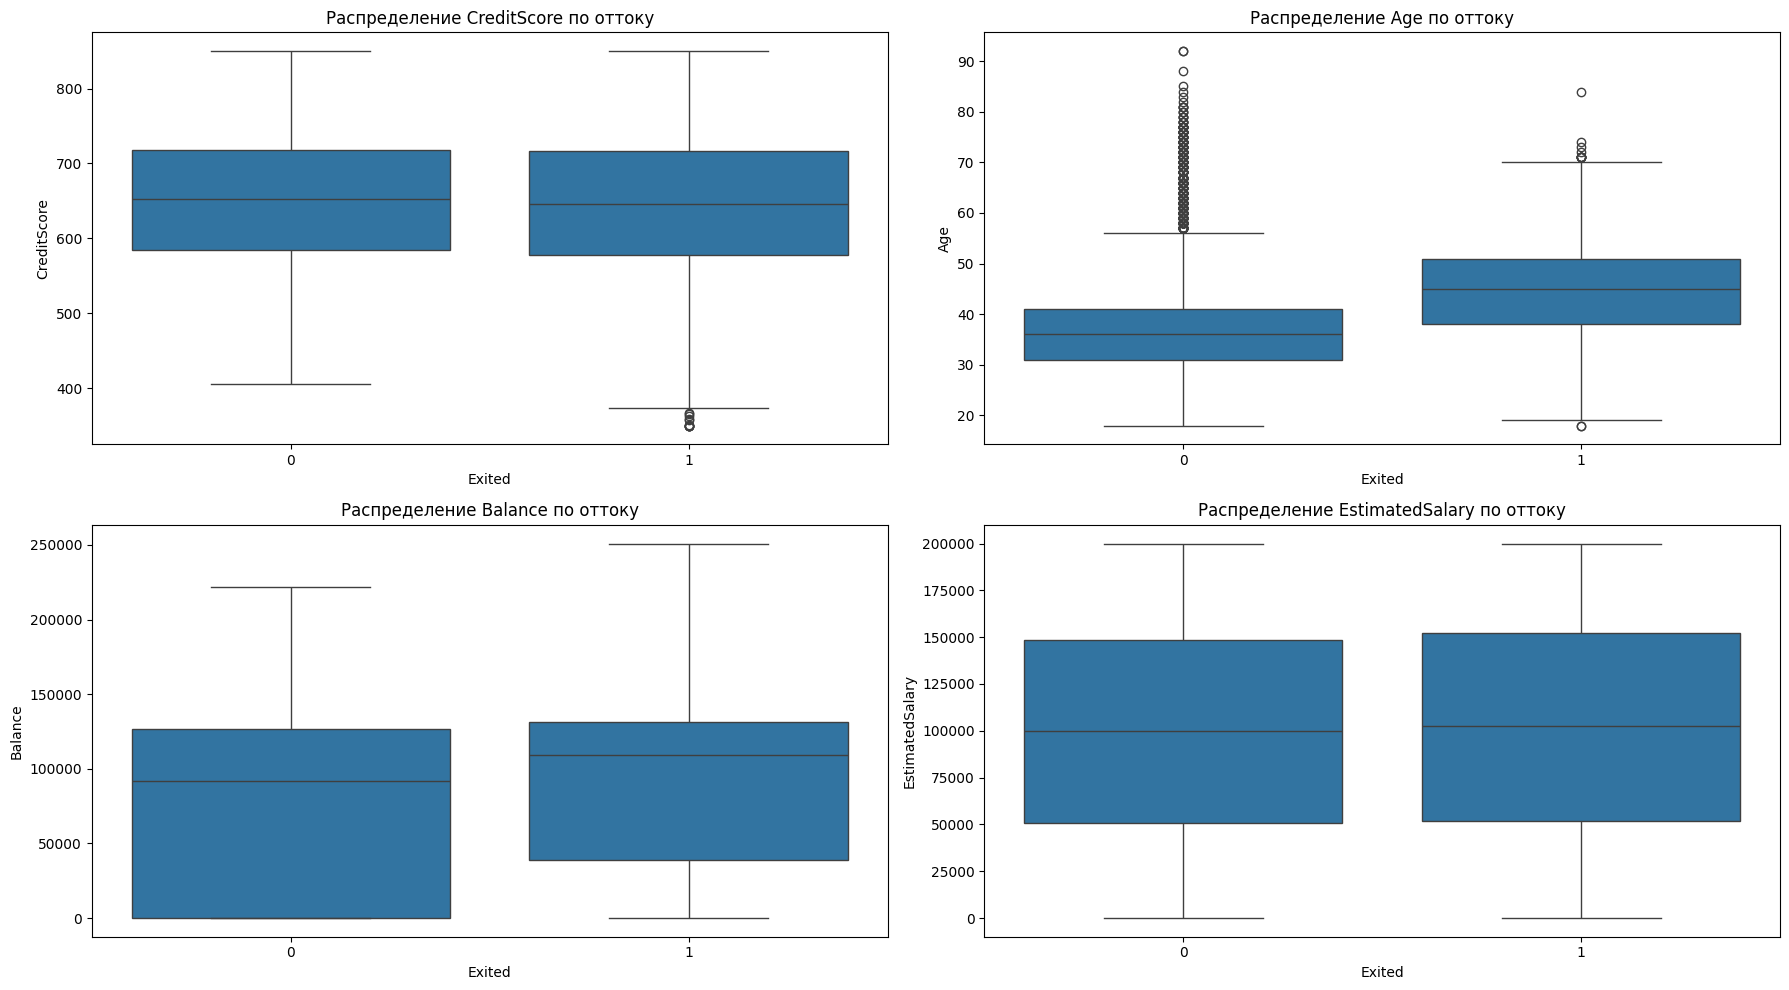

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

for i, col in enumerate(numeric_features):
    ax = axes[i//2, i%2]
    sb.boxplot(data=df, x='Exited', y=col, ax=ax)
    ax.set_title(f'Распределение {col} по оттоку')
    
plt.tight_layout()
plt.show()

По представленным box-plot диаграммам, можем сделать следующие выводы:

- Признак `CreditScore`: Медианы примерно одинаковые, IQR совпадают -> признак слабо влияет на отток в отрыве от других факторов
- Признак `Age`: - Медиана у ушедших клиентов ~44 года vs ~35 лет у лояльных, IQR почти не пересекаются → возраст сильно влияет на отток, Есть выбросы в старшем возрасте (>57 лет). **Вывод:** Клиенты старше 40 лет значительно чаще уходят из банка.
- Признак `Tenure`: Медианы примерно одинаковые, IQR Пересекаются -> признак слабо влияет на отток
- Показатель `Balance`: Медиана у ушедших клиентов ~120000 vs ~90000 у лояльных, IQR перекрываются -> Баланс на счете не сильно влияет на отток; много нулевых балансов, особенно в группе ушедших клиентов
- Принзак `EstimatedSalary`: Медианы примерно одинаковые, IQR совпадают -> признак слабо влияет на отток в отрыве от других факторов

### Давайте теперь построим гистограммы каждого числового признака, чтобы понять, какое распределение они имеют

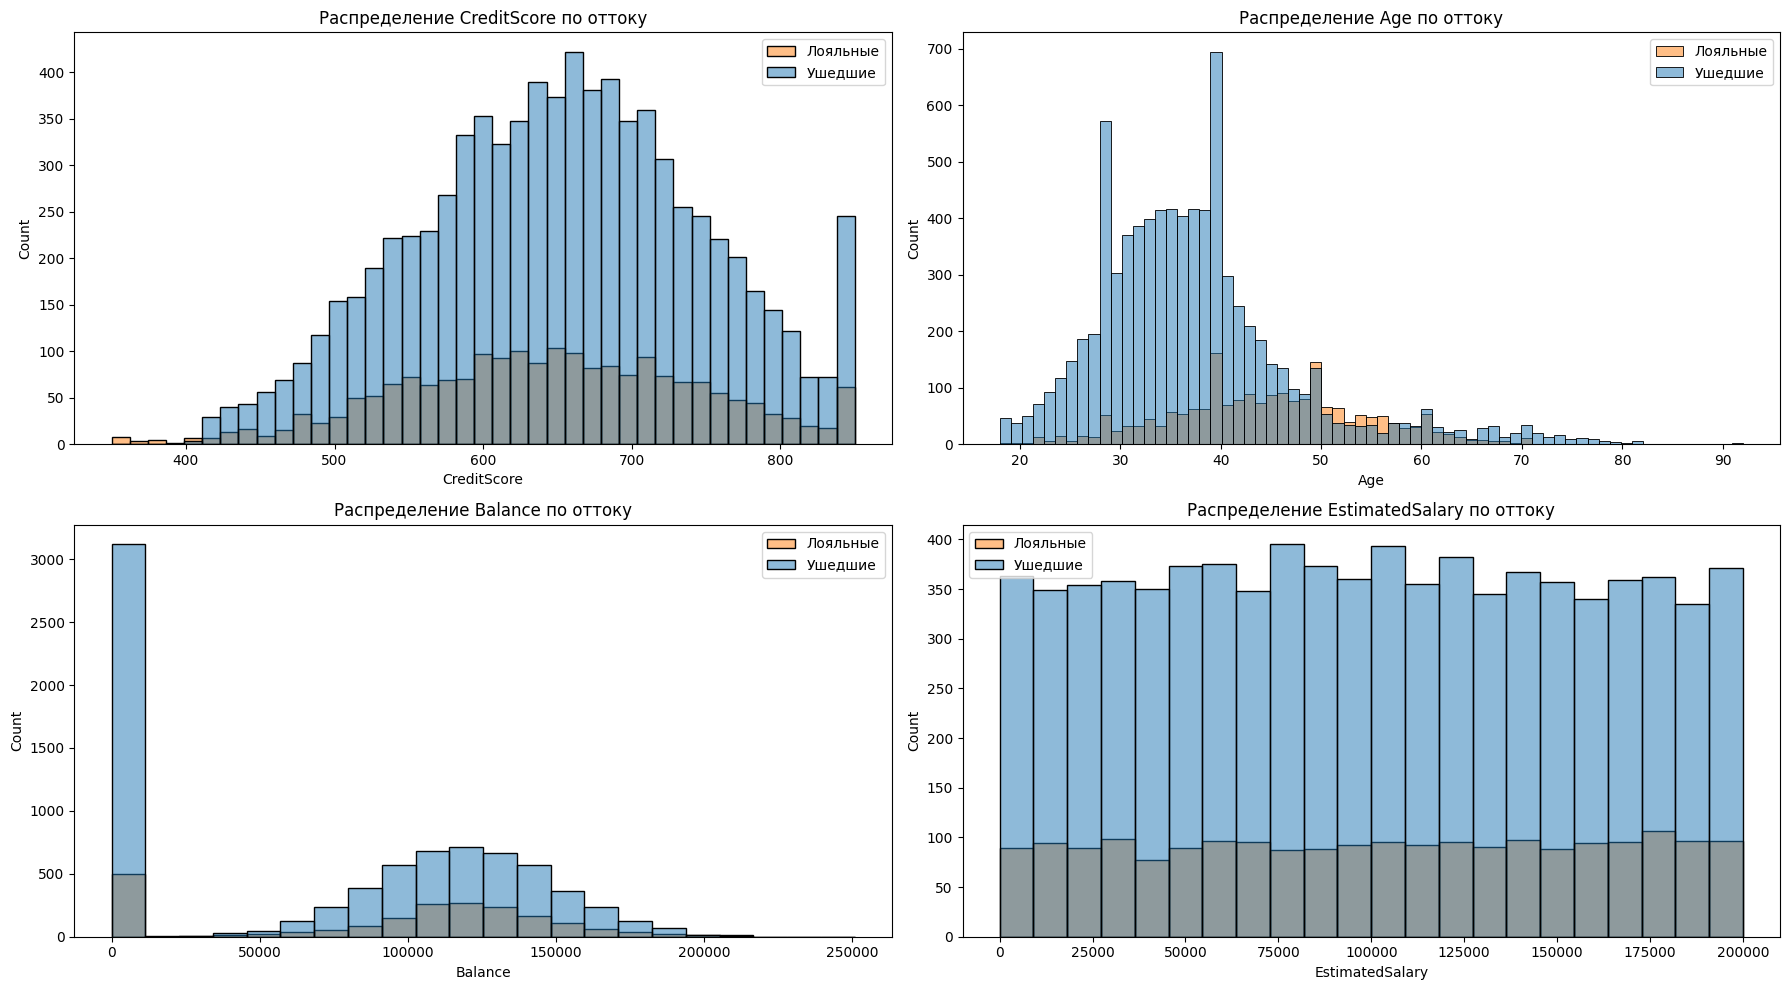

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

for i, col in enumerate(numeric_features):
    ax = axes[i//2, i%2]
    sb.histplot(data=df, x= df[col], hue=target, ax=ax)
    ax.set_title(f'Распределение {col} по оттоку')
    ax.legend(['Лояльные', 'Ушедшие'])
    
plt.tight_layout()
plt.show()

Визуальный анализ гистограмм позволяет сделать следующие выводы о распределении признаков:

- **`CreditScore`**: Распределение приближено к нормальному, однако наблюдается левосторонняя асимметрия с протяженным хвостом в области низких значений, что указывает на смещение среднего относительно медианы.

- **`Age`**: Распределение демонстрирует правостороннюю асимметрию с наличием экстремальных значений в старшей возрастной группе (90+ лет), что свидетельствует о ненормальности распределения.

- **`Balance`**: Наблюдается бимодальное распределение с выраженной концентрацией нулевых значений, что полностью исключает возможность аппроксимации нормальным распределением.

- **`EstimatedSalary`**: Распределение близко к равномерному, без выраженной центральной тенденции, что характерно для искусственно сгенерированных данных.

Проведем тест Шапиро-Уилка, чтобы проверять, являются ли признаки нормально распределенными или нет

In [10]:
from scipy.stats import shapiro

def check_normality_shapiro(df, numeric_features):
    results = {}
    
    for col in numeric_features:
        data = df[col].dropna()
        
        stat, p_value = shapiro(data)
        
        is_normal = p_value > 0.05
        strength = "НОРМАЛЬНОЕ" if is_normal else "НЕ НОРМАЛЬНОЕ"
        
        results[col] = {
            'shapiro_stat': stat,
            'p_value': p_value,
            'is_normal': is_normal,
            'interpretation': strength
        }
    
    return results

normality_results = check_normality_shapiro(df, numeric_features)

print("🔍 Проверка нормальности распределения (Шапиро-Уилк):")
for col, result in normality_results.items():
    print(f"{col}: p-value={result['p_value']:.4f} - {result['interpretation']}")

🔍 Проверка нормальности распределения (Шапиро-Уилк):
CreditScore: p-value=0.0000 - НЕ НОРМАЛЬНОЕ
Age: p-value=0.0000 - НЕ НОРМАЛЬНОЕ
Balance: p-value=0.0000 - НЕ НОРМАЛЬНОЕ
EstimatedSalary: p-value=0.0000 - НЕ НОРМАЛЬНОЕ


c:\Users\kiril\AppData\Local\pypoetry\Cache\virtualenvs\bank-customer-churn-prediction-o7y5BeN5-py3.11\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10002.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\kiril\AppData\Local\pypoetry\Cache\virtualenvs\bank-customer-churn-prediction-o7y5BeN5-py3.11\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10001.
  res = hypotest_fun_out(*samples, **kwds)


**Вывод: распределения имеют ненормальную форму, а значит для проверки гипотез будем использовать критерии Манна-Уитни и хи-квадрат**

## 2.4 Математическое подтверждение гипотез

### Проверим гипотезы, связанные с числовыми признаками, используя критерий Манна-Уитни. Размер эффекта будем считать по формуле рангово-бисериальной корреляции

Для начала заполним пропуск в признаке `Age`, поскольку критерий Манна-Уитни не умеет работать со значения NaN

In [11]:
df.loc[df['Age'].isna(), 'Age'] = df['Age'].mean()

**Критерий Манна-Уитни (U-критерий)** - это тест, который помогает сравнить две независимые группы и понять, есть ли между ними статистически значимые различия. Используем этот критерий, поскольку наши признаки имеют ненормальное распределение, а также данный критерий не чувствителен к выбросам, так как сравниваем не средние значения, а ранги - то есть смотрит, какая группа "выше" или "ниже", без влияния аномальных значений.

Для оценки того, является ли различия статистически значимыми, мы будем также учитывать значения p-value, а также размер эффекта, посчитанный по формуле рангово-бисериальной корреляции: 
`r = 1 - (2U) / (n₁ × n₂)`
где:
- `U` - статистика Манна-Уитни
- `n₁`, `n₂` - объемы сравниваемых выборок
- `r ∈ [-1, 1]` - коэффициент корреляции

### **Статистические гипотезы:**

#### 1. **Кредитный рейтинг (`CreditScore`)**
- **H₀**: Распределения кредитных рейтингов у лояльных и ушедших клиентов идентичны
- **H₁**: Существуют статистически значимые различия в распределениях кредитных рейтингов

#### 2. **Возраст (`Age`)**
- **H₀**: Возрастные распределения лояльных и ушедших клиентов не различаются
- **H₁**: Наблюдаются статистически значимые различия в возрастных распределениях

#### 3. **Баланс счета (`Balance`)**
- **H₀**: Распределения балансов по счетам одинаковы для обеих групп клиентов
- **H₁**: Обнаружены статистически значимые различия в распределениях балансов

#### 4. **Предполагаемая зарплата (`EstimatedSalary`)**
- **H₀**: Распределения предполагаемых зарплат совпадают в сравниваемых группах
- **H₁**: Существуют статистически значимые различия в распределениях зарплат


In [12]:
from scipy.stats import mannwhitneyu
import numpy as np

def mann_whitney_with_effect_size(group_0, group_1):
    stat, p_value = mannwhitneyu(group_0, group_1)
    
    n1, n2 = len(group_0), len(group_1)
    r = 1 - (2 * stat) / (n1 * n2)
    
    r_abs = abs(r)
    
    if r_abs >= 0.5:
        strength = 'Очень сильный'
    elif r_abs >= 0.3:
        strength = 'Сильный' 
    elif r_abs >= 0.1:
        strength = 'Умеренный'
    else:
        strength = 'Слабый'
    
    
    return {
        'p_value': p_value,
        'r_effect_size': r,
        'strength': strength,
        'significant': p_value < 0.05
    }

print("Пересчитаем с размером эффекта r:")
for col in numeric_features:
    group_0 = df[df['Exited'] == 0][col]
    group_1 = df[df['Exited'] == 1][col]
    
    result = mann_whitney_with_effect_size(group_0, group_1)
    
    med_0, med_1 = group_0.median(), group_1.median()
    
    print(f"{col}: p={result['p_value']:.4f}, r={result['r_effect_size']:.3f} "
          f"(медианы: {med_0:.1f} vs {med_1:.1f}) - {result['strength']}")

Пересчитаем с размером эффекта r:
CreditScore: p=0.0209, r=-0.033 (медианы: 653.0 vs 646.0) - Слабый
Age: p=0.0000, r=0.464 (медианы: 36.0 vs 45.0) - Сильный
Balance: p=0.0000, r=0.155 (медианы: 92093.1 vs 109344.2) - Умеренный
EstimatedSalary: p=0.2260, r=0.017 (медианы: 99620.4 vs 102431.9) - Слабый


### **Статистические выводы:**

- **`CreditScore`**: При p < 0.05 отвергаем нулевую гипотезу, однако величина эффекта (r = -0.033) указывает на практическую незначимость выявленных различий.

- **`Age`**: Нулевая гипотеза отвергается (p < 0.001) с сильным размером эффекта (r = 0.464), что подтверждает существенное влияние возраста на вероятность оттока.

- **`Balance`**: Статистически значимые различия обнаружены (p < 0.001) с умеренным размером эффекта (r = 0.155), что свидетельствует о заметном влиянии баланса счета.

- **`EstimatedSalary`**: При p > 0.05 нет оснований отвергать нулевую гипотезу, а пренебрежимо малый размер эффекта (r = 0.017) подтверждает отсутствие практической значимости.

## **Анализ категориальных признаков: критерий хи-квадрат**

### **Методологическое обоснование:**
Критерий хи-квадрат Пирсона применяется для анализа взаимосвязи между категориальными переменными. Метод оценивает значимость расхождений между наблюдаемыми и ожидаемыми частотами в таблицах сопряженности.

**Формула коэффициента Крамера:**
```
V = √(χ² / (n × (min(k, m) - 1)))
```
где:
- `χ²` - статистика хи-квадрат
- `n` - объем выборки
- `k`, `m` - количество категорий в переменных
- `V ∈ [0, 1]` - коэффициент силы связи

### **Статистические гипотезы для категориальных признаков:**

Для каждого категориального признака проверяются гипотезы:

H₀: Признак и отток клиентов статистически независимы

H₁: Существует статистически значимая связь между признаком и оттоком

In [13]:
from scipy.stats import chi2_contingency

def check_categorical_significance(df, categorical_cols):
    results = {}
    for col in categorical_cols:
        contingency_table = pd.crosstab(df[col], df['Exited'])
        
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
        
        results[col] = {
            'p_value': p_value, 
            'significant': p_value < 0.05,
            'cramers_v': cramers_v,
            'interpretation': 'Сильный' if cramers_v > 0.3 else 
                             'Умеренный' if cramers_v > 0.1 else 'Слабый'
        }
    
    return results

cat_significance = check_categorical_significance(df, categorical_features)

for col, result in cat_significance.items():
    print(f"{col}: p-value={result['p_value']:.4f}, Cramér's V={result['cramers_v']:.3f} ({result['interpretation']})")

Geography: p-value=0.0000, Cramér's V=0.174 (Умеренный)
Gender: p-value=0.0000, Cramér's V=0.106 (Умеренный)
NumOfProducts: p-value=0.0000, Cramér's V=0.387 (Сильный)
HasCrCard: p-value=0.5005, Cramér's V=0.007 (Слабый)
IsActiveMember: p-value=0.0000, Cramér's V=0.156 (Умеренный)
Tenure: p-value=0.1744, Cramér's V=0.037 (Слабый)


### **Интерпретация коэффициента Крамера:**
- **0.00-0.09**: Слабая связь
- **0.10-0.29**: Умеренная связь  
- **0.30-0.49**: Сильная связь
- **≥ 0.50**: Очень сильная связь

### **Выводы по категориальным признакам:**

- **`Geography`, `Gender`, `IsActiveMember`**: Отвергаем H₀ (p < 0.001). Обнаружены статистически значимые связи с умеренной силой ассоциации. География, пол и активность клиента умеренно влияют на отток.

- **`NumOfProducts`**: Отвергаем H₀ (p < 0.001). Выявлена сильная статистически значимая связь. Количество продуктов банка является ключевым фактором оттока.

- **`HasCrCard`, `Tenure`**: Не отвергаем H₀ (p > 0.05). Статистически значимой связи с оттоком не обнаружено. Наличие кредитной карты и срок сотрудничества с банком не оказывают существенного влияния на отток.

## 2.5 Корреляционный анализ

Для анализа взаимосвязей между признаками использован **коэффициент корреляции Спирмена**, как наиболее подходящий для данных с ненормальным распределением.

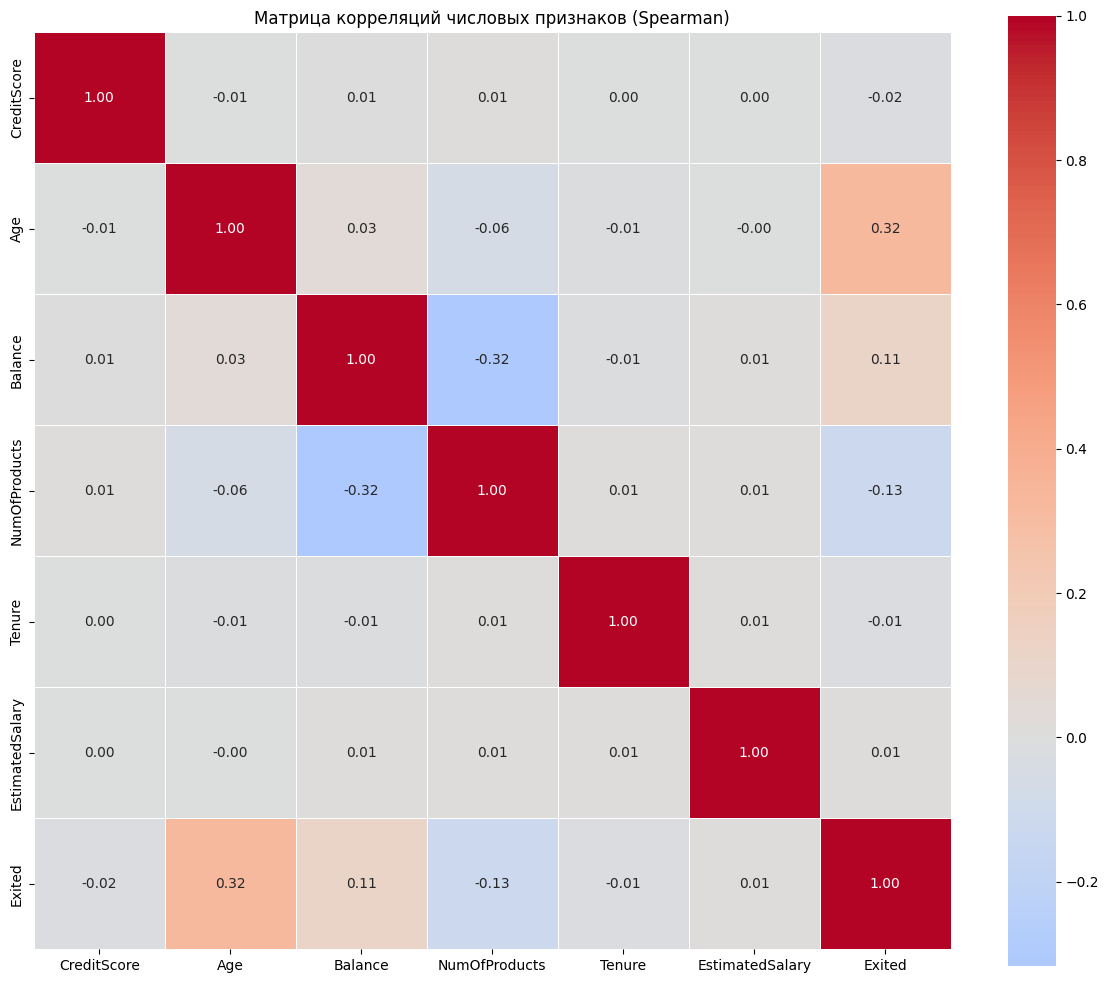

In [14]:
correlation_features = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'Tenure', 'EstimatedSalary', 'Exited']

corr_matrix = df[correlation_features].corr(method='spearman')

plt.figure(figsize=(12, 10))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляций числовых признаков (Spearman)')
plt.tight_layout()
plt.show()

## Анализ мультиколлинеарности и корреляций

### Результаты корреляционного анализа

**Корреляции с целевой переменной (Exited):**
- `Age`: 0.32 (сильная положительная)
- `NumOfProducts`: -0.13 (умеренная отрицательная) 
- `Balance`: 0.11 (умеренная положительная)
- `CreditScore`: -0.02 (незначимая)
- `Tenure`: -0.01 (незначимая)
- `EstimatedSalary`: 0.01 (незначимая)

**Межпризнаковые корреляции:**
Все межпризнаковые корреляции < |0.05|, за исключение одного случая с признаками `NumOfProducts` и `Balance`, что свидетельствует о:
- **Высокой независимости** признаков друг от друга
- **Отсутствии дублирующей информации** в фичах
- **Возможности использования всех признаков** без риска переобучения
- **Стабильности оценок коэффициентов** в линейных моделях

### Согласованность с статистическим анализом

Корреляционный анализ подтверждает ранее полученные результаты:

**Сильное влияние:**
- `Age` (0.32) - сильная положительная корреляция с оттоком
  - Старшие клиенты чаще уходят ← подтверждено

**Умеренное влияние:**  
- `Balance` (0.11) - слабая положительная корреляция
- `NumOfProducts` (-0.13) - слабая отрицательная корреляция
  - Больше продуктов → меньше отток ← подтверждено

**Незначимое влияние:**
- `CreditScore` (-0.02), `Tenure` (-0.01), `EstimatedSalary` (0.01)
  - Практически нулевая корреляция с оттоком ← подтверждено

### Ключевые выводы

1. **Валидация гипотез**: Корреляционный анализ подтвердил результаты статистических тестов
2. **Качество признаков**: Все признаки независимы и несут уникальную информацию
3. **Готовность к моделированию**: Отсутствие мультиколлинеарности позволяет использовать все признаки без предварительного отбора

### Рекомендации для этапа моделирования
- Использовать полный набор признаков
- Приоритет: Tree-based models (CatBoost, LightGBM) 
- Линейные модели также применимы благодаря стабильности признаков